In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from tqdm import tqdm

from skyburst import Job, Node, Cluster
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

import logging
logger = logging.getLogger()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
jobs = philly.load_philly_traces('~/philly-traces/trace-data')
jobs.sort(key=lambda j: j._submitted_time)
all_jobs = jobs

In [3]:
from math import floor, ceil

# Maximum job time in hours
CLIP_MAX_TIME = 1e9

# Deadline Multiplier d_t = a_t + K * r_t
DEADLINE_CONSTANT = 1.25

# Returns the deadline of a job.
# For continuous simulator
def deadline_mult_fn(arrival_time, run_time, resource_dict, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = max(1/12.0, waiting_time)
    return arrival_time + waiting_time + run_time


def deadline_mult_cap_fn(arrival_time, run_time, resource_dict, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = min(48, max(1/12.0, waiting_time))
    return arrival_time + waiting_time + run_time

def deadline_ljw(arrival_time, run_time, resource_dict, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
    if run_time < run_thres:
        return arrival_time + run_time
    waiting_time = (deadline_mult - 1)*run_time
    return arrival_time + waiting_time + run_time

def deadline_infinite_fn(arrival_time, run_time, resource_dict):
    return 1e12

def deadline_zero_fn(arrival_time, run_time, resource_dict):
    return arrival_time + run_time

def deadline_constant_fn(arrival_time, run_time, resource_dict, wait_time=1):
    return arrival_time + wait_time + run_time

def deadline_linear_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * resource_dict['GPUs'] + run_time

def deadline_quad_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * (resource_dict['GPUs']**2) + run_time

def deadline_log_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    if resource_dict['GPUs'] ==0:
        return arrival_time + run_time
    return arrival_time + deadline_mult * (1+np.log2(resource_dict['GPUs'])) + run_time

def deadline_area_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * resource_dict['GPUs'] * run_time + run_time

# Returns the total cost of a job.
def gpu_cost_fn(resources: dict, run_time: float):
    return resources['GPUs'] * run_time

def time_thres_fn(job, run_thres):
    return job.runtime >= run_thres

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

# Num nodes
NUM_NODES = 16

def preprocess_jobs(jobs: List['JobTrace'], deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]
    
    # Run time for jobs
    run_times = [j._run_time/60.0 for j in jobs]
    
    # Get GPU resources
    resources = []
    for j in jobs:
        gpu_count = sum([len(node_dict['gpus']) for node_dict in j.attempts[-1]['detail']])
        resources.append({'GPUs': gpu_count})
    
    deadlines = [deadline_fn(arrival, run, resource_dict) for arrival, run, resource_dict in zip(arrival_times, run_times, resources)]  
    costs = [cost_fn(res, run) for res, run in zip(resources, run_times)]
    
    return [Job(idx, arr, run, dead, res, cost) \
            for idx, (arr, run, dead, res, cost) in \
            enumerate(list(zip(arrival_times, run_times, deadlines, resources, costs)))]

def generate_steady_state(jobs: List['JobTrace'], num_jobs = 100000, arrival_param=32.0, deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn):
    """Converts a list of jobs into Job(arrival_time, run_time, deadline, resources, cost).
    """
    num_jobs = int(num_jobs)
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    #num_jobs = len(jobs)
    
    # Arrival time for jobs
    np.random.seed(2024)
    interarrival_times = np.random.exponential(scale=1/arrival_param, size=num_jobs-1)
    interarrival_times = np.insert(interarrival_times, 0, 0)
    arrival_times = np.cumsum(interarrival_times)
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        run_time_hr = j._run_time/60.0
        run_times.append(run_time_hr)

    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    np.random.seed(2024)
    job_indexes = np.random.choice(list(range(len(run_times))), size=num_jobs, replace=True)
    proc_jobs = []
    for idx in range(num_jobs):
        job_idx = job_indexes[idx]
        #job_idx = idx
        resources_dict = resources[job_idx]
        runtime = run_times[job_idx]
        deadline = deadline_fn(arrival_times[idx], runtime, resources_dict)
        cost = cost_fn(resources_dict, runtime)
        proc_jobs.append(Job(idx, arrival_times[idx], runtime, deadline, resources_dict, cost))
    return proc_jobs

In [4]:
def is_subset(list1, list2):
    indexes = []
    for i2, elem in enumerate(list2):
        for i1,x in enumerate(list1):
            if x == elem and i1 not in indexes:
                indexes.append(i1)
                break
        if len(indexes) !=  i2+1:
            return []
    return indexes

In [5]:
## Attempt Pre-emption
# Add job into the cluster -> pre empt jobs (what jobs to preempt?)
# Only preempt jobs that have reached deadline & are cheaper than the current job
# Preempted jobs go back into the queue
# Warning very slow!
def continuous_simulator(jobs: List[Job], policy, num_nodes, job_filter_policy=None, verbose=False, debug=False):
    original_policy_str = copy.deepcopy(policy)
    if '-' in policy:
        policy_list = policy.split('-')
        policy = policy_list[0]
        mods = policy_list[1:]
    else:
        mods = []
    
    if policy == 'fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'lifo':
        sort_func = lambda x: -x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'evdf':
        sort_func = lambda x: x.deadline * x.num_gpus
    elif policy == 'ldf':
        sort_func = lambda x: -x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    elif policy == 'swf':
        sort_func = lambda x: x.deadline - x.runtime 
    elif policy == 'svwf':
        sort_func = lambda x: (x.deadline - x.runtime)*x.num_gpus
    elif policy == 'lwf':
        sort_func = lambda x: -x.deadline + x.runtime
    else:
        pass
        #raise ValueError(f'Policy {policy} does not match!')
    
    bin_pack_policy = 'first-fit'
    remove_hol = False
    backfill = False
    for mod in mods:
        if mod == 'nohol':
            remove_hol=True
        if mod == 'backfill':
            backfill=True
        if mod == 'first':
            bin_pack_policy = 'first-fit'
        if mod == 'best':
            bin_pack_policy = 'best-fit'
        if mod == 'worst':
            bin_pack_policy = 'worst-fit'
    
    job_filter_fn = None
    if job_filter_policy is not None:
        job_filter_policy, run_thres = job_filter_policy.split('-')
        if job_filter_policy == 'ljw':
            job_filter_fn = lambda x: time_thres_fn(x, float(run_thres))
        else:
            raise ValueError(f'Incorrect job filter policy {job_filter_policy}.')
    
    finished_jobs = []
    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)
    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, backfill=backfill, binpack=bin_pack_policy)
    t=0
    #tqdm_iter = tqdm(total=len(jobs), desc ="# of Jobs left")
    while len(jobs) >0 or len(queue)>0 or cluster.active_jobs:
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        i=0
        while i < len(queue):
            job = queue[i]
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                job.state = 'TIMEOUT-CLOUD'
                job.start = job.deadline - job.runtime
                finished_jobs.append(job)
            else:
                i+=1
        
        # Add jobs to queue that have arrived
        i=0
        while i < len(jobs):
            job = jobs[i]
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
                
            if job.arrival == t:
                jobs.remove(job)
                #tqdm_iter.update(1)
#                 if job.idx%1000==0:
#                     logging.info(f'{policy}-{num_nodes}: {job.idx}')
                if job_filter_fn is not None:
                    # If arrival job does not satisfy job filter, move job to cloud.
                    if not job_filter_fn(job):
                        job.state = 'FILTER-CLOUD'
                        finished_jobs.append(job)
                        continue
                queue.append(job)
            else:
                break
        
        if policy == 'llf':
            sort_func = lambda x: x.deadline - t - x.runtime
        elif policy == 'llfv':
            sort_func = lambda x: (x.deadline - t - x.runtime)*x.num_gpus
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        i =0
        while i < len(queue):
            job = queue[i]
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            elif not remove_hol:
                break
            else:
                i+=1
        
        # Perform EASY backfilling
        if backfill:
            # Reserve the first element of queue that is blocking
            if queue:
                job_to_reserve = queue[0]
                can_reserve = cluster.try_reserve(t, job_to_reserve)
                # If can't reserve within reasonble time (before deadline), move the job to the cloud
                if not can_reserve:
#                     job_to_reserve.block_job_idx = 'hi'
                    pass
#                     queue.remove(job_to_reserve)
#                     job_to_reserve.state = 'FILTER-CLOUD'
#                     job_to_reserve.start = t
#                     finished_jobs.append(job_to_reserve)
                else:
                    queue.remove(job_to_reserve)
                i=0
                while i < len(queue):
                    job = queue[i]
                    can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
                    if can_fit:
                        queue.remove(job)
                        queue.extend(preempted_jobs)
                    else:
                        i+=1
                    
        next_time_list = []
        
        # Skip to next timestep where a new job either arrives or when a job finishes on the cluster.
        for job_idx, job in cluster.active_jobs.items():
            release_time = job.start + job.runtime
            next_time_list.append(release_time)

        if len(jobs)>0:
            next_time_list.append(jobs[0].arrival)
        
        if len(next_time_list)==0:
            assert len(queue)==0 and len(jobs) ==0
            break
        
        if min(next_time_list) < t:
            raise ValueError('Simulator is severely bugged; Raise a Git Issue.')
                
        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t = min(next_time_list)
    finished_jobs.extend(cluster.try_clear(1e12))
    assert len(jobs)==0 and len(queue)==0

    # Compute Avg. Waiting Time
    total_waiting_time = 0.0
    num_jobs = 0
    for job in finished_jobs:
        # remove warmup and cooldown period
        if job.idx < 2000 or job.idx > len(finished_jobs)-2000:
            continue
        # Moved to cloud
        if job.state == 'TIMEOUT-CLOUD':
            total_waiting_time += job.start - job.arrival
            cloud_cost += job.cost
        elif job.state == 'FILTER-CLOUD':
            assert job.start is not None
            total_waiting_time += job.start - job.arrival
            cloud_cost += job.cost
        elif job.state == 'LOCAL':
            assert job.state == 'LOCAL'
            total_waiting_time += job.start - job.arrival
        num_jobs+=1
    
    policy = original_policy_str
    print(f'{policy}-{num_nodes}')
    print(f'Cloud Cost ({policy}-{num_nodes}): {cloud_cost}')
    print(f'Avg Waiting Time ({policy}-{num_nodes}): {total_waiting_time/num_jobs}')
    print(len(finished_jobs))
    return f'{policy}-{num_nodes}', save_simulator_results(finished_jobs)

def save_simulator_results(finished_jobs: List[Job]) -> dict:
    result_dict = {
        'idx': [],
        'arrival': [],
        'start': [],
        'runtime': [],
        'deadline': [],
        'num_gpus': [],
        'state': [],
        'allocated_gpus': [],
    }
    finished_jobs.sort(key = lambda x: x.idx)
    for job in finished_jobs:
        result_dict['idx'].append(job.idx)
        result_dict['arrival'].append(job.arrival)
        if job.start is not None:
            result_dict['start'].append(job.start)
        else:
            result_dict['start'].append(-1)
        result_dict['runtime'].append(job.runtime)
        result_dict['deadline'].append(job.deadline)
        result_dict['num_gpus'].append(job.num_gpus)
        result_dict['state'].append(job.state)
        result_dict['allocated_gpus'].append(job.allocated_gpus)
    result_dict['idx'] = np.array(result_dict['idx'])
    result_dict['arrival'] = np.array(result_dict['arrival'])
    result_dict['start'] = np.array(result_dict['start'])
    result_dict['runtime'] = np.array(result_dict['runtime'])
    result_dict['deadline'] = np.array(result_dict['deadline'])
    result_dict['num_gpus'] = np.array(result_dict['num_gpus'])
    result_dict['state'] = np.array(result_dict['state'])
    result_dict['allocated_gpus'] = np.array(result_dict['allocated_gpus'])
    return result_dict

In [6]:
temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=1.25)
linear_jobs_proc = generate_steady_state(all_jobs, 120000, arrival_param=32.0, deadline_fn=temp_fn)

#preprocess_jobs(all_jobs, deadline_fn=const_fn)
total_wait = sum([j.deadline - j.arrival - j.runtime for j in linear_jobs_proc])


def deadline_linear_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * resource_dict['GPUs'] + run_time

def deadline_quad_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    waiting_time = deadline_mult * (resource_dict['GPUs']**2)
    waiting_time = min(48, max(1/12.0, waiting_time))
    return arrival_time +  waiting_time + run_time

def deadline_log_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    if resource_dict['GPUs'] ==0:
        return arrival_time + run_time
    return arrival_time + deadline_mult * (1+np.log2(resource_dict['GPUs'])) + run_time

def deadline_exact_log_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * (np.log(512) - np.log(512-resource_dict['GPUs'])) + run_time

constant_thres = total_wait/120000
const_fn = lambda x, y,z: deadline_constant_fn(x,y,z,wait_time=constant_thres)
print(f'Constant Threshold: {constant_thres}')

gpu_list = np.array([j.num_gpus for j in linear_jobs_proc])
linear_capacity_thres = total_wait/np.sum(gpu_list)
linear_capacity_func = lambda x, y,z: deadline_linear_capacity_fn(x,y,z,deadline_mult=linear_capacity_thres)
print(f'Linear Capacity Threshold: {linear_capacity_thres}')

quad_capacity_thres = total_wait/np.sum(np.array(gpu_list)**2)
quad_capacity_func = lambda x, y,z: deadline_quad_capacity_fn(x,y,z,deadline_mult=quad_capacity_thres)
print(f'Quad Capacity Threshold: {quad_capacity_thres}')

exact_log_capacity_thres = total_wait/np.sum((np.log(512) - np.log(512-gpu_list)))
exact_log_capacity_func = lambda x, y,z: deadline_exact_log_capacity_fn(x,y,z,deadline_mult=exact_log_capacity_thres)
print(f'Exact Log Capacity Threshold: {exact_log_capacity_thres}')

log_capacity_thres = total_wait/np.sum(1+ np.log2(gpu_list[gpu_list>0]))
log_capacity_func = lambda x, y,z: deadline_log_capacity_fn(x,y,z,deadline_mult=log_capacity_thres)
print(f'Log Capacity Threshold: {log_capacity_thres}')


jobs_proc = generate_steady_state(all_jobs, num_jobs=120000, arrival_param=32.0, deadline_fn=temp_fn)
asdf1 = continuous_simulator(jobs_proc, 'fifo', 72)

# asdf1 = continuous_simulator(jobs_proc_1, 'fifo', 36)
# asdf2 = continuous_simulator(jobs_proc, 'fifo-backfill', 72)
# asdf3 = continuous_simulator(jobs_proc, 'fifo-backfill-best', 72)

Constant Threshold: 1.0766557384249589
Linear Capacity Threshold: 0.8118096162149624
Quad Capacity Threshold: 0.18128849242915723
Exact Log Capacity Threshold: 413.73020629747134
Log Capacity Threshold: 0.9368405305995156
fifo-72
Cloud Cost (fifo-72): 5012.668055555565
Avg Waiting Time (fifo-72): 0.008792319386675091
120000


In [ ]:
algs = ['fifo', 'lifo', 'svjf', 'lvjf', 'swf']
algs = algs + [alg+'-backfill' for alg in algs]

#num_nodes = [72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136] #[105, 110, 120, 125]
arrival_params = list(range(12, 85, 4))

print(algs)
def steady_state_search(jobs, algs, arrival_params, num_nodes, deadline_fn):
    tuples = []
    zip_tuples = []
    for arrival_param in arrival_params:
        jobs_proc = generate_steady_state(jobs, 120000, \
                arrival_param=arrival_param, deadline_fn=deadline_fn)
        for alg in algs:
            tuples.append((jobs_proc, alg, num_nodes))
            zip_tuples.append(f'{alg}-{arrival_param}')
    results = []
    with multiprocessing.Pool(processes=48) as pool:
        results = pool.starmap(continuous_simulator, tuples)
    results_dict = {}
    assert len(results) == len(zip_tuples)
    for k1, k2 in zip(zip_tuples, results):
            results_dict[k1] = k2[1]
    return results_dict
    
# 64 nodes, deadline=1.25 linear
for build in ['nowait', 'constant', 'linear', 'constant-nohol', 'linear-nohol', 'linear-backfill']:
    if build == 'nowait':
        temp_fn = deadline_zero_fn
        algs = ['fifo']
    elif build == 'constant':
        temp_fn = const_fn
        algs = ['fifo']
    elif build == 'linear':
        temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=1.25)
        algs = ['fifo']
    elif build == 'constant-nohol':
        temp_fn = const_fn
        algs = ['fifo-nohol']
    elif build == 'linear-nohol':
        temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=1.25)
        algs = ['fifo-nohol']
    elif build == 'linear-backfill':
        temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=1.25)
        algs = ['fifo-backfill']
    else:
        raise ValueError('lmao')
    hybrid_results = steady_state_search(all_jobs, algs, arrival_params, 64, temp_fn)
    file = open(f'logs/poisson/build/{build}.log', 'wb')
    pickle.dump(hybrid_results, file)
    file.close()


# temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=1.25)
# for ddl in [1, 1.25]:
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#         algs = ['fifo']
#     else:
#         temp_fn = lambda x, y, z: deadline_mult_cap_fn(x,y,z,deadline_mult=ddl)
#         algs = ['fifo', 'lifo', 'svjf', 'lvjf', 'swf']
#         algs = algs + [alg+'-backfill' for alg in algs]
#     hybrid_results = steady_state_search(all_jobs, algs, arrival_params, 64, temp_fn)
#     file = open(f'logs/poisson/linear_cap/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()

# algs = ['fifo', 'lifo', 'svjf', 'lvjf', 'swf']
# deadline_dict = {'exact_log':exact_log_capacity_func, 'linear': linear_capacity_func, 
# 'quad': quad_capacity_func, 'log': log_capacity_func, 'nowait': deadline_zero_fn, 'constant': const_fn}
# for func_type in ['constant']: #['exact_log', 'linear', 'quad', 'log']:
#     hybrid_results = steady_state_search(all_jobs, algs, arrival_params, 64, deadline_dict[func_type])
#     file = open(f'logs/poisson/vary_capacity/{func_type}_philly_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()


    


['fifo', 'lifo', 'svjf', 'lvjf', 'swf', 'fifo-backfill', 'lifo-backfill', 'svjf-backfill', 'lvjf-backfill', 'swf-backfill']
fifo-64
Cloud Cost (fifo-64): 0
Avg Waiting Time (fifo-64): 0.0
120000
fifo-64
Cloud Cost (fifo-64): 0
Avg Waiting Time (fifo-64): 0.0
120000
fifo-64
Cloud Cost (fifo-64): 0.14222222222222222
Avg Waiting Time (fifo-64): 0.0
120000
fifo-64
Cloud Cost (fifo-64): 762.7933333333334
Avg Waiting Time (fifo-64): 0.0
120000
fifo-64
Cloud Cost (fifo-64): 25409.975833333338
Avg Waiting Time (fifo-64): -5.880302982988907e-18
120000
fifo-64
Cloud Cost (fifo-64): 87915.31999999999
Avg Waiting Time (fifo-64): -2.4501262429120444e-18
120000
fifo-64
Cloud Cost (fifo-64): 191628.0755555556
Avg Waiting Time (fifo-64): -1.9601009943296354e-18
120000
fifo-64
Cloud Cost (fifo-64): 298946.85472222214
Avg Waiting Time (fifo-64): -1.0045517595939383e-17
120000
fifo-64
Cloud Cost (fifo-64): 393876.4827777771
Avg Waiting Time (fifo-64): -1.0290530220230587e-17
120000
fifo-64
Cloud Cost (fi

In [9]:
algs = ['fifo', 'lifo', 'sjf', 'svjf', 'ljf', 'lvjf', 'edf', 'ldf', 'swf', 'lwf']
algs = ['fifo', 'lifo', 'svjf', 'lvjf', 'swf']

#num_nodes = [72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136] #[105, 110, 120, 125]
num_nodes = list(range(24, 150, 4))

def continuous_hyperparameter_search(jobs, algs, nodes_list, deadline_fn, job_filter_policy=None):
    jobs_proc = preprocess_jobs(jobs, deadline_fn=deadline_fn)
    tuples = []
    for n_nodes in nodes_list:
        for alg in algs:
            tuples.append((jobs_proc, alg, n_nodes, job_filter_policy))
    results = []
    with multiprocessing.Pool(processes=63) as pool:
        results = pool.starmap(continuous_simulator, tuples)
    results_dict = {}
    for r in results:
        results_dict[r[0]] = r[1]
    return results_dict

algs = ['fifo', 'lifo', 'svjf', 'lvjf', 'swf']
deadline_dict = {'exact_log':exact_log_capacity_func, 'linear': linear_capacity_func, 
'quad': quad_capacity_func, 'log': log_capacity_func, 'nowait': deadline_zero_fn}
for func_type in ['exact_log']:
    hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, deadline_dict[func_type])
    file = open(f'logs/vary_capacity_nodes/{func_type}_philly_cont.log', 'wb')
    pickle.dump(hybrid_results, file)
    file.close()

# print(algs)
# for hours_wait in [0, 0.5, 1, 2]:
#     temp_fn = lambda x,y,z: deadline_constant_fn(x, y, z, = wait_time=hours_wait)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/constant/cjw_philly_{hours_wait}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()


# print(algs)
# capacity_fn = lambda x,y,z: deadline_capacity_fn(x,y,z, deadline_mult=0.7912912710329504)
# hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                   deadline_fn=capacity_fn)
# file = open(f'logs/capacity/capacity_philly_0.8_cont.log', 'wb')
# pickle.dump(hybrid_results, file)
# file.close()


# print(algs)
# capacity_fn = lambda x,y,z: deadline_mult_cap_fn(x,y,z, deadline_mult=0.25)
# hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                   deadline_fn=capacity_fn)
# file = open(f'logs/cap/cap_philly_0.25_cont.log', 'wb')
# pickle.dump(hybrid_results, file)
# file.close()


# algs = [f'{alg}' for alg in algs]
# print(algs)
# for ddl in [1, 1.25, 1.5]:
#     print(ddl)
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/none/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()

    
# algs = [f'{alg}-backfill' for alg in algs]
# print(algs)
# for ddl in [1.25, 1.5]:
#     print(ddl)
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/backfill-new/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()


# algs = [f'{alg}-best' for alg in algs]
# print(algs)
# for ddl in [1.25, 1.5]:
#     print(ddl)
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/best/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()


# algs = [f'{alg}-backfill-best' for alg in algs]
# print(algs)
# for ddl in [1.25, 1.5]:
#     print(ddl)
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/backfill-best/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()

# algs = [f'{alg}-best' for alg in algs]
# print(algs)
# for ddl in [1.25, 1.5]:
#     print(ddl)
#     if ddl==1:
#         temp_fn = deadline_zero_fn
#     elif ddl == 100000:
#         temp_fn = deadline_infinite_fn
#     else:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#     hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                       deadline_fn=temp_fn)
#     file = open(f'logs/best/vjw_philly_{ddl}_cont.log', 'wb')
#     pickle.dump(hybrid_results, file)
#     file.close()
    
    
    
# for ddl in [1.5]:
#     for preempt_thres in [1/10.0, 1/8.0, 1/5.0, 1/2.0]:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#         hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                           deadline_fn=temp_fn, preempt=preempt_thres)
#         file = open(f'logs/vjw_philly_{ddl}_preempt_{preempt_thres}_cont.log', 'wb')
#         pickle.dump(hybrid_results, file)
#         file.close()

# def deadline_ljw(arrival_time, run_time, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
#     if run_time < run_thres:
#         return arrival_time + run_time
#     waiting_time = (deadline_mult - 1)*run_time
#     return arrival_time + waiting_time + run_time
# for run_thres in [1]:
#     for ddl in [1.5]:
#         temp_fn = lambda x, y: deadline_mult_fn(x,y,deadline_mult=ddl)
#         hybrid_results = continuous_hyperparameter_search(all_jobs, algs, num_nodes, \
#                                                           deadline_fn=temp_fn, job_filter_policy = f'ljw-{run_thres}')
#         file = open(f'logs/vjw_philly_{ddl}_{run_thres}_cont.log', 'wb')
#         pickle.dump(hybrid_results, file)
#         file.close()


fifo-24
Cloud Cost (fifo-24): 713068.5711110875
Avg Waiting Time (fifo-24): 0.9801530719172087
83154
lvjf-24
Cloud Cost (lvjf-24): 707821.1486110893
Avg Waiting Time (lvjf-24): 1.0144740736708069
83154
fifo-28
Cloud Cost (fifo-28): 671812.8463888693
Avg Waiting Time (fifo-28): 0.9501123824640513
83154
lifo-24
Cloud Cost (lifo-24): 714828.026666662
Avg Waiting Time (lifo-24): 0.631299184454808
83154
lvjf-28
Cloud Cost (lvjf-28): 659192.131388871
Avg Waiting Time (lvjf-28): 1.0062692474378314
83154
svjf-24
Cloud Cost (svjf-24): 721124.9922222188
Avg Waiting Time (svjf-24): 0.5119481336540325
83154
fifo-32
Cloud Cost (fifo-32): 623392.189999983
Avg Waiting Time (fifo-32): 0.9274634853184018
83154
lvjf-32
Cloud Cost (lvjf-32): 598931.881666655
Avg Waiting Time (lvjf-32): 0.990245636636752
83154
swf-24
Cloud Cost (swf-24): 717046.3005555527
Avg Waiting Time (swf-24): 0.8204307803316865
83154
svjf-28
Cloud Cost (svjf-28): 673137.3824999956
Avg Waiting Time (svjf-28): 0.4995230795391235
83154

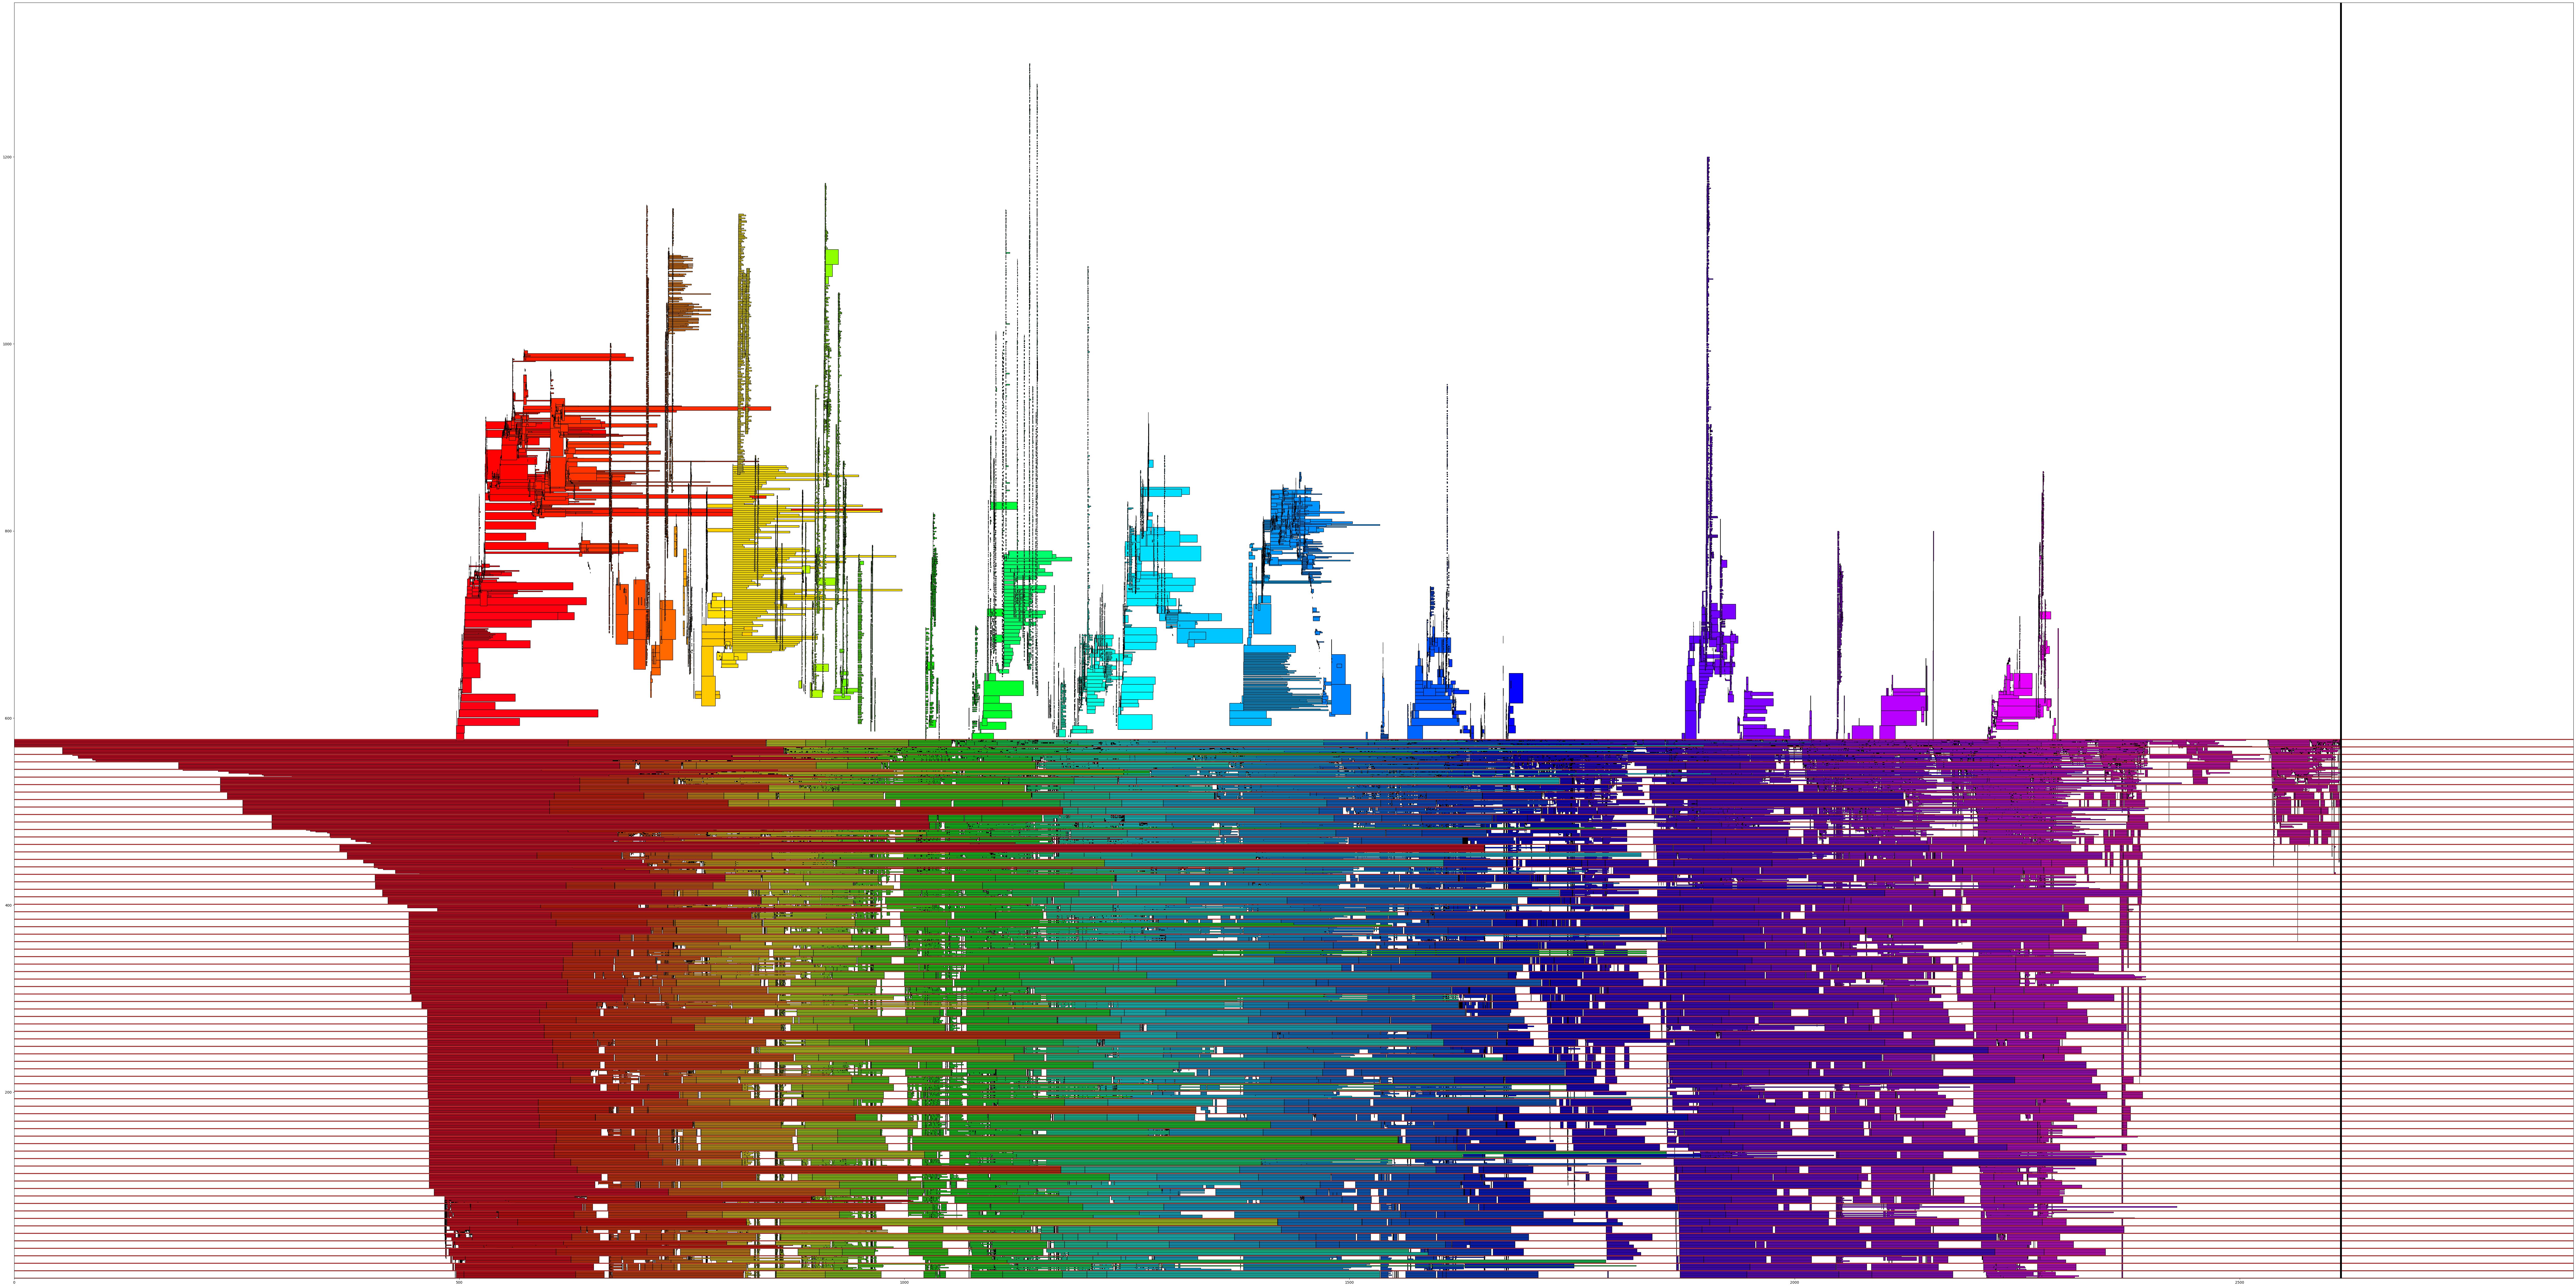

In [ ]:
plot_trace_spacetime_and_spillover(asdf[1], 72)